# Create dataset

In [1]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# combine game data
df1 = pd.read_csv('data/large_board_dataset2.csv')
df2 = pd.read_csv('data/large_board_dataset3.csv')
df3 = pd.read_csv('data/large_board_dataset4.csv')
df4 = pd.read_csv('data/large_board_dataset5.csv')
df5 = pd.read_csv('data/large_board_dataset6.csv')

# fix game numbers
df2['game'] += df1['game'].max() + 1
df3['game'] += df2['game'].max() + 1
df4['game'] += df3['game'].max() + 1
df5['game'] += df4['game'].max() + 1

# combine dfs
df = pd.concat([df1, df2, df3, df4, df5])

# to save memory
del df1, df2, df3, df4, df5

print(f'Length of dataset {len(df)}')

Length of dataset 327457


In [3]:
# include game info
df1 = pd.read_csv('data/large_board_dataset2_game_info.csv')
df2 = pd.read_csv('data/large_board_dataset3_game_info.csv')
df3 = pd.read_csv('data/large_board_dataset4_game_info.csv')
df4 = pd.read_csv('data/large_board_dataset5_game_info.csv')
df5 = pd.read_csv('data/large_board_dataset6_game_info.csv')

# fix game numbers
df2['game'] += df1['game'].max() + 1
df3['game'] += df2['game'].max() + 1
df4['game'] += df3['game'].max() + 1
df5['game'] += df4['game'].max() + 1

info_df = pd.concat([df1, df2, df3, df4, df5]).reset_index(drop=True)
info_df['who_won'] = info_df['who_won'].str.replace(r'\w-', '', regex=True)
info_df.head()

df = df.merge(info_df, on='game')

del df1, df2, df3, df4, df5, info_df

In [4]:
# change boards to np arrays
df["x"] = df["x"].apply(lambda x: np.array(ast.literal_eval(x)).reshape(2, 6, 7))

# change perspective for yellow to be the same as red (switch the first index or switch the last index once we fix shape)
def switch_players(board):
    if board["whose_turn"] != "red":
        # Flip the layers to make each board look like it's from the perspective of "red", aka plus
        board["x"] = board["x"][::-1, :, :]
    return board

df = df.apply(switch_players, axis=1)

def flip_board(board, col):
    new_board = np.flip(board, axis = 2)
    # for now this needs to be done by index 2 because the input is still 2x6x7, but this can easily be updated
    new_column = 6 - col
    return new_board, new_column

flipped_x = []
flipped_y = []

for index, row in df.iterrows():
    board = row["x"]
    col = row["y"]
    new_board, new_column = flip_board(board, col)

    flipped_x.append(new_board)
    flipped_y.append(new_column)

new_df = pd.DataFrame({"x": flipped_x, "y": flipped_y})

# insert matching previous columns
new_df = pd.concat([new_df, df.loc[:, 'whose_turn':'who_won']], axis=1)
new_df['game'] += 15000

# append the df of flipped boards
df = pd.concat([df, new_df], ignore_index = True)

# create tuple again
df['x_tuple'] = df['x'].apply(lambda x:tuple(x.ravel())) # save tuple for later use in exploration (couldn't use arrays)

# remove to save memory
del new_df

In [5]:
df.shape

(654914, 9)

There are 563450 unique x's in our dataset.
86.03% of the x's are unique in our dataset.
There are 30000 games in our dataset.


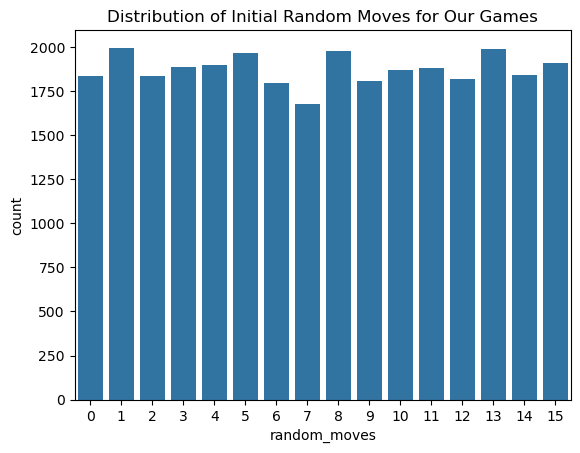

Relatively equal distribution of random moves

Games each player won


who_won
yellow    14874
red       13862
tie        1264
Name: count, dtype: int64


These are all the first moves that were played and their frequency:


y
3    1742
4      43
2      43
1       4
5       4
6       1
0       1
Name: count, dtype: int64

You can see that MCTS has picked up on that the middle column is the best first move.


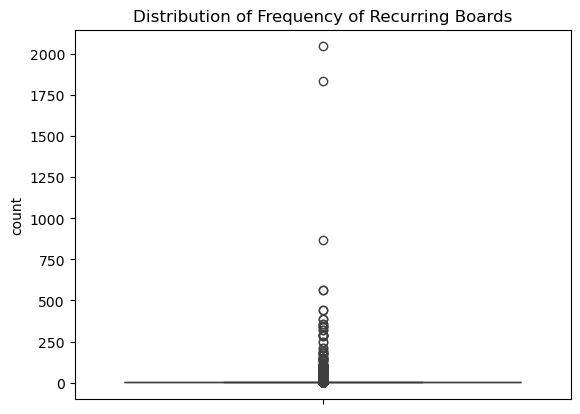

Most recurring boards only occur twice, but some occur as many as 1000 times.
There are 25392 recurring boards that we could potentially restrict moves for.


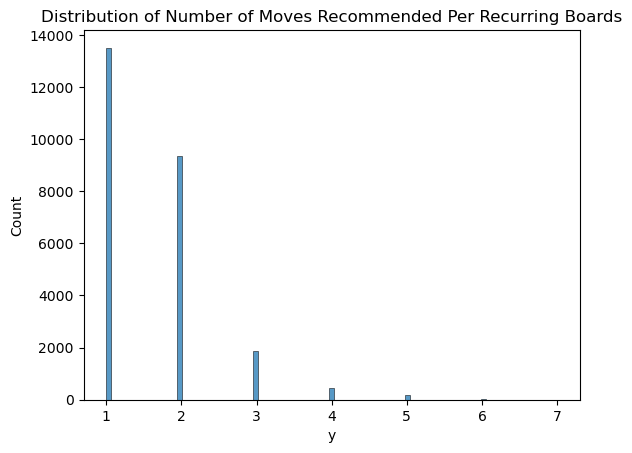

Some of the recurring boards only select one move. The choice is clear there. Should look into what to select for the boards with more than one move.

How should we decide to remove moves from the dataset? Should we make sure that a move has been a certain proportion of times out of more than x moves?
Of those recurring boards, 4391 of them are played more than 10 times, and we could select the most common move for boards with more than 10 moves.
Alternatively, we could select moves for the 1840 boards with more than 20 moves in our dataset.


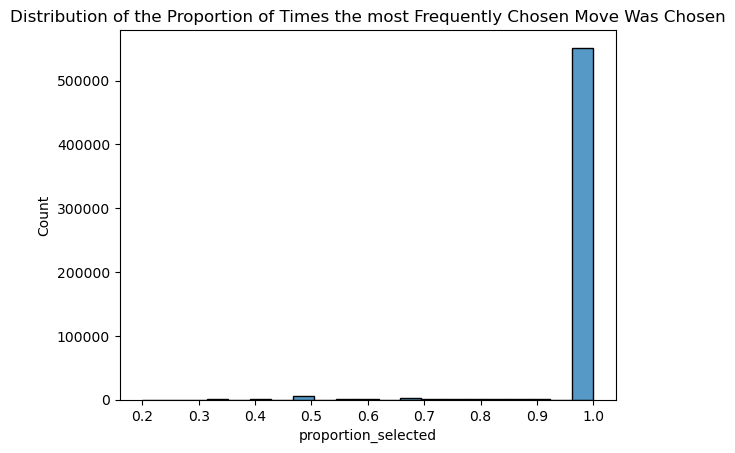

This is for recurring and non-recurring boards. If a board doesn't occur multiple times, then the most frequently occurring move is selected 1/1 times.


In [6]:
# examine games

# unique x's?
unique_x = df['x_tuple'].nunique()
print(f'There are {unique_x} unique x\'s in our dataset.')
perc_unique_x = unique_x / df.shape[0] * 100
print(f'{perc_unique_x:.2f}% of the x\'s are unique in our dataset.')

# Number of games
print(f'There are {df['game'].nunique()} games in our dataset.')

# Distribution of random moves
random_moves = df.groupby('game').first()['random_moves'].value_counts()
sns.barplot(x = random_moves.index, y = random_moves)
plt.title('Distribution of Initial Random Moves for Our Games')
plt.show()
print('Relatively equal distribution of random moves')

# How many games did each player win?
print('\nGames each player won')
wins = df.groupby('game').first()['who_won'].value_counts()
display(wins)

# What is the diversity of moves?
# First moves
first_moves = df[df['random_moves'] == 0].groupby('game')['y'].first()
print('\nThese are all the first moves that were played and their frequency:')
display(first_moves.value_counts())
print('You can see that MCTS has picked up on that the middle column is the best first move.')

# Hoe often do recurring boards occur?
board_counts = df['x_tuple'].value_counts()
sns.boxplot(board_counts[board_counts>1])
plt.title('Distribution of Frequency of Recurring Boards')
plt.show()
print('Most recurring boards only occur twice, but some occur as many as 1000 times.')

# For repeated boards, what is the consensus among moves?
recurring_boards_s = pd.Series(board_counts[board_counts > 1].index)
print(f'There are {len(recurring_boards_s)} recurring boards that we could potentially restrict moves for.')
recurring_boards_df = df[df['x_tuple'].isin(recurring_boards_s)]
n_moves = recurring_boards_df.groupby('x_tuple')['y'].nunique()
sns.histplot(n_moves)
plt.title('Distribution of Number of Moves Recommended Per Recurring Boards')
plt.show()
print('Some of the recurring boards only select one move. The choice is clear there. Should look into what to select for the boards with more than one move.')


moves_counts_df = df.groupby('x_tuple')['y'].value_counts().reset_index()
total_moves = df.groupby('x_tuple')['y'].count().reset_index().rename(columns = {'y':'total_moves'})
moves_counts_df = moves_counts_df.merge(total_moves, on='x_tuple')
moves_counts_df['proportion_selected'] = moves_counts_df['count'] / moves_counts_df['total_moves']

# How should we decide to remove moves from the dataset?
print('\nHow should we decide to remove moves from the dataset? Should we make sure that a move has been a certain proportion of times out of more than x moves?')
print(f'Of those recurring boards, {len(moves_counts_df[moves_counts_df['total_moves'] >= 10])} of them are played more than 10 times, and we could select the most common move for boards with more than 10 moves.')
print(f'Alternatively, we could select moves for the {len(moves_counts_df[moves_counts_df['total_moves'] >= 20])} boards with more than 20 moves in our dataset.')

# Distribution of the proportion of times the most frequently chosen moves
sns.histplot(moves_counts_df.groupby('x_tuple')['proportion_selected'].max())
plt.title('Distribution of the Proportion of Times the most Frequently Chosen Move Was Chosen')
plt.show()
print('This is for recurring and non-recurring boards. If a board doesn\'t occur multiple times, then the most frequently occurring move is selected 1/1 times.')
      
# Get the most frequent move for all boards
most_frequent_moves_df = moves_counts_df.loc[moves_counts_df.groupby('x_tuple')['proportion_selected'].idxmax()]

# # How many rows would we remove if we select moves recommended more than 80% of the time?
# rows_removed = most_frequent_moves_df.loc[most_frequent_moves_df['proportion_selected'] > .8, 'total_moves'].sum() - len(most_frequent_moves_df.loc[most_frequent_moves_df['proportion_selected'] > .8])
# print(f'We could remove {rows_removed} rows if we selected moves that have 80% selection rate. This doesn\'t account for sample size though.')

# rows_removed = most_frequent_moves_df.loc[
#         (most_frequent_moves_df['proportion_selected'] > .8) &
#         (most_frequent_moves_df['total_moves']>=10), 'total_moves'
#     ].sum() -\
#     len(most_frequent_moves_df.loc[most_frequent_moves_df['proportion_selected'] > .8])


In [8]:
# # selecting filters
# selection_rate_thresh = [0.5, 0.6, 0.7, 0.8]

# # record the most frequent move for each board
# move_mapping = most_frequent_moves_df.set_index('x_tuple')['y']
# df['most_frequent_move'] = df['x_tuple'].map(move_mapping)

# for thresh in selection_rate_thresh:
#     # Get the boards whose most frequent move meets our threshold
#     # Will restrict moves for this board
#     board_meets_threshold = most_frequent_moves_df.loc[most_frequent_moves_df['proportion_selected'] >= thresh, 'x_tuple']
    
#     # Get the boards whose most frequent move doesn't meet our threshold (
#     # Won't restrict moves for these boards
#     board_doesnt_meet_threshold = most_frequent_moves_df.loc[most_frequent_moves_df['proportion_selected'] < thresh, 'x_tuple']

#     # Filter boards
#     filtered_boards = df[(df['x_tuple'].isin(board_meets_threshold)) & (df['y'] == df['most_frequent_move'])]
#     filtered_boards = filtered_boards.drop_duplicates(subset='x_tuple') # Need to remove duplicates
#     unfiltered_boards = df[df['x_tuple'].isin(board_doesnt_meet_threshold)] # don't decide on a move if we aren't confident
#     # We could play more games for the boards that we are uncertain what the best move is to find the best move nd then reduce our dataset?

#     # Create new df
#     new_df = pd.concat([filtered_boards, unfiltered_boards])

#     # Record number of rows dropped
#     rows_dropped = df.shape[0] - new_df.shape[0]
#     print(f'With {thresh} threshold, {rows_dropped} rows dropped.')

With 0.5 threshold, 77013 rows dropped.
With 0.6 threshold, 61396 rows dropped.
With 0.7 threshold, 49090 rows dropped.
With 0.8 threshold, 41369 rows dropped.


In [14]:
# # selecting filters (with win check)
# # selecting filters
# selection_rate_thresh = [0.5, 0.6, 0.7, 0.8]

# # what is the diversity of boards if we restrict to games that current player won
# print(df.loc[df['whose_turn'] == df['who_won'], 'x_tuple'].nunique())

# # record the most frequent move for each board
# move_mapping = most_frequent_moves_df.set_index('x_tuple')['y']
# df['most_frequent_move'] = df['x_tuple'].map(move_mapping)

# for thresh in selection_rate_thresh:
#     # Get the boards whose most frequent move meets our threshold
#     # Will restrict moves for this board
#     board_meets_threshold = most_frequent_moves_df.loc[most_frequent_moves_df['proportion_selected'] >= thresh, 'x_tuple']
    
#     # Filter boards
#     filtered_boards = df[
#         (df['x_tuple'].isin(board_meets_threshold)) & 
#         (df['y'] == df['most_frequent_move']) &
#         (df['whose_turn'] == df['who_won'])
#     ]
#     filtered_boards = filtered_boards.drop_duplicates(subset='x_tuple') # Need to remove duplicates
    
#     # Get the boards whose most frequent move doesn't meet our threshold
#     # Won't restrict moves for these boards
#     unfiltered_boards = df[~df['x_tuple'].isin(filtered_boards['x_tuple'])] # don't decide on a move if we aren't confident
#     # We could play more games for the boards that we are uncertain what the best move is to find the best move nd then reduce our dataset?

#     # Create new df
#     new_df = pd.concat([filtered_boards, unfiltered_boards])

#     # Record number of rows dropped
#     rows_dropped = df.shape[0] - new_df.shape[0]
#     print(f'With {thresh} threshold, {rows_dropped} rows dropped.')

With 0.5 threshold, 63222 rows dropped.
With 0.6 threshold, 52122 rows dropped.
With 0.7 threshold, 41866 rows dropped.
With 0.8 threshold, 34905 rows dropped.


In [12]:
# # selecting filters (with min moves)
# selection_rate_thresh = [0.5, 0.6, 0.7, 0.8]
# min_moves = 10

# # record the most frequent move for each board
# move_mapping = most_frequent_moves_df.set_index('x_tuple')['y']
# df['most_frequent_move'] = df['x_tuple'].map(move_mapping)

# for thresh in selection_rate_thresh:
#     # Get the boards whose most frequent move meets our threshold
#     # Will restrict moves for this board
#     board_meets_threshold = most_frequent_moves_df.loc[
#     ((most_frequent_moves_df['proportion_selected'] >= thresh) &
#     (most_frequent_moves_df['total_moves'] >= min_moves))
#     , 'x_tuple']
    
#     # Get the boards whose most frequent move doesn't meet our threshold
#     # Won't restrict moves for these boards
#     board_doesnt_meet_threshold = most_frequent_moves_df.loc[~most_frequent_moves_df['x_tuple'].isin(board_meets_threshold), 'x_tuple']

#     # Filter boards
#     filtered_boards = df[(df['x_tuple'].isin(board_meets_threshold)) & (df['y'] == df['most_frequent_move'])]
#     filtered_boards = filtered_boards.drop_duplicates(subset='x_tuple') # Need to remove duplicates
#     unfiltered_boards = df[df['x_tuple'].isin(board_doesnt_meet_threshold)] # don't decide on a move if we aren't confident
#     # We could play more games for the boards that we are uncertain what the best move is to find the best move nd then reduce our dataset?

#     # Create new df
#     new_df = pd.concat([filtered_boards, unfiltered_boards])

#     # Record number of rows dropped
#     rows_dropped = df.shape[0] - new_df.shape[0]
#     print(f'With {thresh} threshold, {rows_dropped} rows dropped.')

With 0.5 threshold, 35406 rows dropped.
With 0.6 threshold, 29131 rows dropped.
With 0.7 threshold, 23017 rows dropped.
With 0.8 threshold, 18024 rows dropped.


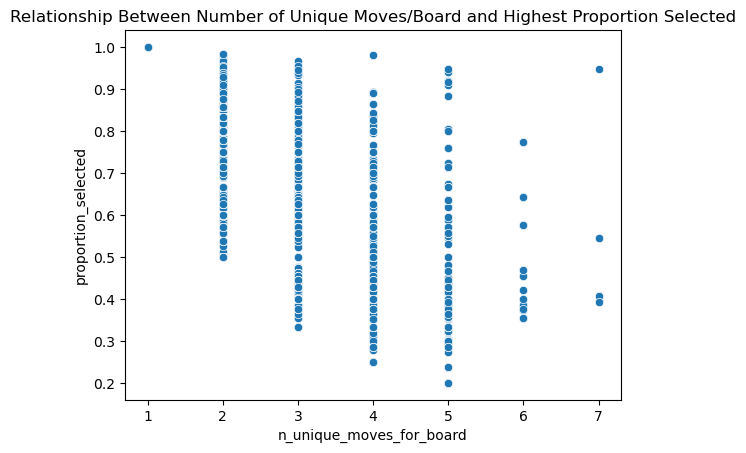

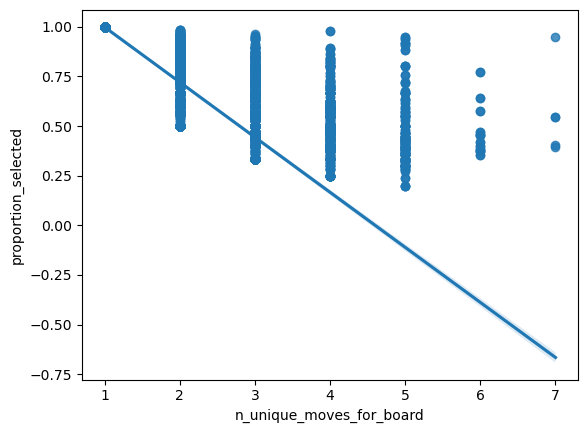

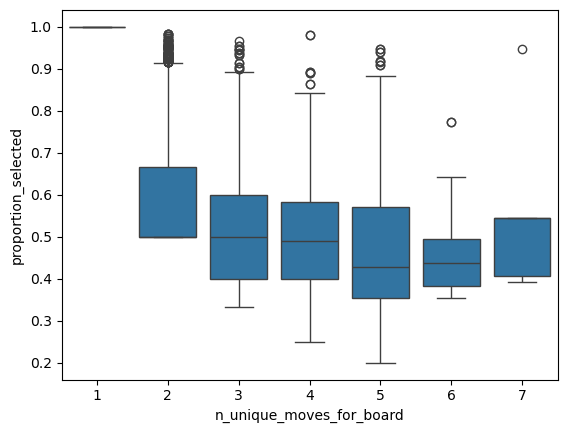

We are determining the filter for selection rate based on the meaan selection rate across boards with n unique moves. This is what we are usng as the dynamic threshold.


n_unique_moves_for_board
1    1.000000
2    0.584509
3    0.518239
4    0.497640
5    0.477575
6    0.472826
7    0.566841
Name: proportion_selected, dtype: float64

Number of boards we are selecting the most frequent moves for: 271296
Number of moves for those boards: 294826
Number of additional moves dropped for those boards 294826
Number of unfiltered boards: 292154
Unfiltered boards length 327370
With 0.5 threshold, 56248 rows dropped.


In [33]:
# decide on final dynamic filter to use (with win check)

# record the most frequent move for each board
move_mapping = most_frequent_moves_df.set_index('x_tuple')['y']
df['most_frequent_move'] = df['x_tuple'].map(move_mapping)

# record the selection rate for the most frequent move for each board
proportion_mapping = most_frequent_moves_df.set_index('x_tuple')['proportion_selected']
df['most_frequent_move_prop_selected'] = df['x_tuple'].map(proportion_mapping)

# record the number of unique moves for each board
n_moves = df.groupby('x_tuple')['y'].nunique()
df['n_unique_moves_for_board'] = df['x_tuple'].map(n_moves)

# Look at how the proportion selected is related to the number of unique moves per board
plot_df = df[df['most_frequent_move']==df['y']].drop_duplicates(subset='x_tuple') # only look at boards where the most frequent move won
plot_df = plot_df.merge(most_frequent_moves_df[['x_tuple', 'proportion_selected']], on='x_tuple')
sns.scatterplot(x = plot_df['n_unique_moves_for_board'], y = plot_df['proportion_selected'])
plt.title('Relationship Between Number of Unique Moves/Board and Highest Proportion Selected')
plt.show()
sns.regplot(x = plot_df['n_unique_moves_for_board'], y = plot_df['proportion_selected'])
plt.show()
sns.boxplot(x = plot_df['n_unique_moves_for_board'], y = plot_df['proportion_selected'])
plt.show()

# Determine dynamic filter using the mean proportion selected for each board with n unique moves
dynamic_thresh = plot_df.groupby('n_unique_moves_for_board')['proportion_selected'].mean()
print('We are determining the filter for selection rate based on the meaan selection rate across boards with n unique moves. This is what we are usng as the dynamic threshold.')
display(dynamic_thresh)
df['dynamic_thresh'] = df['n_unique_moves_for_board'].map(dynamic_thresh)

# Get the boards whose most frequent move meets our threshold
# Will restrict moves for this board
board_meets_threshold = (df['most_frequent_move_prop_selected'] >= df['dynamic_thresh'])

# Filter boards
filtered_boards = df[
    board_meets_threshold & 
    (df['y'] == df['most_frequent_move']) &
    (df['whose_turn'] == df['who_won'])
]
print(f'Number of boards we are selecting the most frequent moves for: {filtered_boards['x_tuple'].nunique()}')
print(f'Number of moves for those boards: {filtered_boards.shape[0]}')
print(f'Number of additional moves dropped for those boards {filtered_boards.duplicated(subset='x_tuple', keep='first').shape[0]}')
filtered_boards = filtered_boards.drop_duplicates(subset='x_tuple') # Need to remove duplicates

# Get the boards whose most frequent move doesn't meet our threshold
# Won't restrict moves for these boards
unfiltered_boards = df[~df['x_tuple'].isin(filtered_boards['x_tuple'])] # don't decide on a move if we aren't confident
print(f'Number of unfiltered boards: {unfiltered_boards['x_tuple'].nunique()}')
print(f'Unfiltered boards length {unfiltered_boards.shape[0]}')
# We could play more games for the boards that we are uncertain what the best move is to find the best move nd then reduce our dataset?

# Create new df
new_df = pd.concat([filtered_boards, unfiltered_boards])

# Record number of rows dropped
rows_dropped = df.shape[0] - new_df.shape[0]
print(f'With {thresh} threshold, {rows_dropped} rows dropped.')

In [34]:
# Not missing any boards from the original dataset
new_boards = pd.Series(new_df['x_tuple'].unique())
old_boards = pd.Series(df['x_tuple'].unique())
old_boards.isin(new_boards).mean()

1.0

In [35]:
# Save the unfiltered dataset 
#################################
# as .pkl
df.to_pickle("data/654914moves_2-6-7shape.pkl")
# test
df_loaded = pd.read_pickle("data/654914moves_2-6-7shape.pkl")
display(df_loaded)


# Change format of board
#################################
# what it looked like before
display(df.loc[0, 'x'])

# convert shape
df['x'] = df['x'].apply(lambda x:x.transpose(1, 2, 0))  # Convert (num_samples, 2, 6, 7) to (num_samples, 6, 7, 2)

# check it worked
display(df.loc[0, 'x'])

# Save the dataset as .pkl
df.to_pickle("data/654914moves_6-7-2shape.pkl")
# test
df_loaded = pd.read_pickle("data/654914moves_6-7-2shape.pkl")
display(df_loaded)

,x,y,whose_turn,opponent_level,player_level,game,random_moves,who_won,x_tuple,most_frequent_move,most_frequent_move_prop_selected,n_unique_moves_for_board,dynamic_thresh
0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...",0,red,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1.0,1,1.000000
1,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...",4,yellow,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0.5,2,0.584509
2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...",3,red,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,1.0,1,1.000000
3,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...",4,yellow,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,1.0,1,1.000000
4,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...",3,red,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,1.0,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
654909,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0...",3,yellow,1500,1500,29999,14,yellow,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",3,1.0,1,1.000000
654910,"[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1...",3,red,1500,1500,29999,14,yellow,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",3,1.0,1,1.000000
654911,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0...",2,yellow,1500,1500,29999,14,yellow,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",2,1.0,1,1.000000
654912,"[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1...",4,red,1500,1500,29999,14,yellow,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",4,1.0,1,1.000000


array([[[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 1., 0., 1., 0.]]])

array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 1.]],

       [[0., 0.],
        [0., 1.],
        [0., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.]]])

,x,y,whose_turn,opponent_level,player_level,game,random_moves,who_won,x_tuple,most_frequent_move,most_frequent_move_prop_selected,n_unique_moves_for_board,dynamic_thresh
0,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",0,red,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1.0,1,1.000000
1,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",4,yellow,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0.5,2,0.584509
2,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",3,red,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,1.0,1,1.000000
3,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",4,yellow,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,1.0,1,1.000000
4,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",3,red,1500,1500,0,7,red,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,1.0,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
654909,"[[[0.0, 1.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",3,yellow,1500,1500,29999,14,yellow,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",3,1.0,1,1.000000
654910,"[[[1.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",3,red,1500,1500,29999,14,yellow,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",3,1.0,1,1.000000
654911,"[[[0.0, 1.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",2,yellow,1500,1500,29999,14,yellow,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",2,1.0,1,1.000000
654912,"[[[1.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",4,red,1500,1500,29999,14,yellow,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",4,1.0,1,1.000000


In [36]:
# save the filtered data
new_df = new_df[['x', 'y']]

# convert shape
new_df['x'] = new_df['x'].apply(lambda x:x.transpose(1, 2, 0))  # Convert (num_samples, 2, 6, 7) to (num_samples, 6, 7, 2)

new_df.to_pickle('data/6-7-2shape_cleaned.pkl')

# Test
df_loaded = pd.read_pickle('data/6-7-2shape_cleaned.pkl')
display(df_loaded)

# Get a random subset to make training easier
subset_df = new_df.sample(frac=0.5, random_state=42)
subset_df.to_pickle('data/6-7-2shape_cleaned_subset.pkl')

,x,y
0,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",0
2,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",3
4,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",3
6,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",4
8,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",1
...,...,...
654904,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",4
654906,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",6
654908,"[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",0
654910,"[[[1.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....",3


In [37]:
# Get a random subset to make training easier
subset_df = new_df.sample(frac=0.5, random_state=42)
subset_df.to_pickle('data/6-7-2shape_cleaned_subset.pkl')